In [1]:
import numpy as np
import matplotlib.pyplot as plt
import serial as Serial
import scipy.interpolate
from PIL import Image

# Generate sample image

In [2]:
# I generate a large image, with square proportions, to allow for some anti-aliasing, I guess.

sz = 2048
large = np.zeros([sz,sz])
large.shape

(2048, 2048)

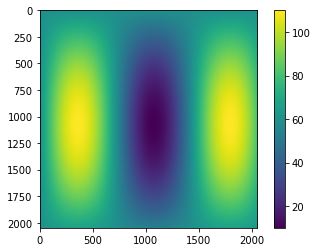

In [3]:
ns = np.linspace(0, np.pi*3, large.shape[0])
XX,YY = np.meshgrid(ns, ns)

ZZ = np.sin(XX*3/np.pi) * np.sin(YY/np.pi*1) * 50 + 60

plt.imshow(ZZ, interpolation=None)
plt.colorbar()

# Discretize image file

In [4]:
#load image (ZZ)

#resample into 256x256 points
def resample(image, res = 256):
    vecIn = np.linspace(0, 1, image.shape[0])
    XX, YY = np.meshgrid(vecIn, vecIn)
    interpolator = scipy.interpolate.interp2d(XX, YY, image)
    vecOut = np.linspace(0, 1, res)
    
    return interpolator(vecOut, vecOut)

    #Does not work for large-ish file sizes.
    

In [5]:
# PIL approach
n = 128
image = Image.fromarray(ZZ)
resized = image.resize((n,n), resample=Image.BILINEAR)
#easy.

# Generate set of strings

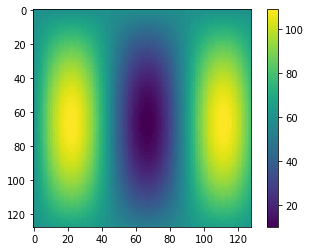

In [6]:
resizedArr = np.array(resized.getdata(), dtype=int).reshape(n,n)
plt.imshow(resizedArr)
plt.colorbar()

In [7]:
resizedArr

array([[60, 60, 60, ..., 60, 60, 60],
       [60, 60, 60, ..., 60, 60, 60],
       [60, 60, 60, ..., 61, 61, 61],
       ...,
       [60, 61, 61, ..., 65, 64, 64],
       [60, 60, 61, ..., 64, 64, 63],
       [60, 60, 61, ..., 64, 63, 63]])

In [8]:
listOfStrings = []
for i in range(resizedArr.shape[1]):
    tempString = ""
    for j in range(resizedArr.shape[0]):
        tempString += str(resizedArr[i,j]) + ' '
    listOfStrings.append(tempString)

In [9]:
listOfStrings[0]

'60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 '

In [10]:
listOfStrings[64]

'61 65 68 72 75 78 81 85 87 90 93 96 98 100 102 104 105 107 108 108 109 109 109 109 109 108 107 106 105 103 101 99 97 95 92 90 87 84 81 77 74 71 67 64 60 57 53 50 46 43 40 37 33 31 28 25 23 20 18 16 15 13 12 11 10 10 10 10 10 10 11 12 13 15 16 18 20 23 25 28 30 33 36 40 43 46 50 53 57 60 64 67 70 74 77 80 84 87 89 92 95 97 99 101 103 105 106 107 108 109 109 109 109 109 108 108 107 105 104 102 100 98 96 93 90 88 85 82 '

# Pass to uController

The set of relevant commands are:
```cpp
    // Define relevant callback functions for the command structure
    sCmd.addCommand("MAN",      enableJoystick);
    sCmd.addCommand("REM",      disableJoystick);
    sCmd.addCommand("SCAN",     parseScanCommand);
    sCmd.addCommand("STEP",     setStepSize);
    sCmd.addCommand("MOVE",     parseMoveCommand);
    sCmd.addCommand("MOVETO",   parseMoveToCommand);
    sCmd.addCommand("GETPOS",   returnPosition);
    sCmd.addCommand("HOME",     homeAllAxis);
    sCmd.addCommand("HOMEX",    Xhome);
    sCmd.addCommand("HOMEY",    Yhome);
    sCmd.addCommand("CENTER",     setCenter);
    sCmd.addCommand("OPEN",     openShutter);
    sCmd.addCommand("CLOSE",    closeShutter);
    sCmd.setDefaultHandler(unrecognized);
```


### Timeline of commands:
 - Position manually to center position
 - Define as center position (CENTER command)
 - Define stepsize
 - Send line with SCAN command
 - Wait for functional response
 - Send next line with SCAN command
   - Repeat as necessary.

In [11]:
def readAll():
    if ser.is_open:
        returnString = str(ser.read(ser.inWaiting()))
        print(returnString)

In [12]:
ser = Serial.Serial(port='/dev/tty.usbmodem1414201', baudrate=115200)

In [72]:
ser.open()

In [71]:
ser.close()

In [75]:
ser.write(b'MAN\n')

4

In [83]:
readAll()

b'RETURN: Line finished, 67 numbers received.\r\nRETURN: Shutter open.\r\nRETURN: Shutter closed.\r\nRETURN: Shutter closed.\r\n'


In [73]:
ser.write(b'CENTER\n')

7

In [74]:
ser.write(b'OPEN\n')

5

In [82]:
byteStringA = b'SCAN ' + str.encode(listOfStrings[64][:220]) + b' \n'
ser.write(byteStringA)
byteStringA

b'SCAN 61 65 68 72 75 78 81 85 87 90 93 96 98 100 102 104 105 107 108 108 109 109 109 109 109 108 107 106 105 103 101 99 97 95 92 90 87 84 81 77 74 71 67 64 60 57 53 50 46 43 40 37 33 31 28 25 23 20 18 16 15 13 12 11 10 10 10 1 \n'

In [77]:
byteString = b'SCAN   10 10 10 10 10 10 10 10 10 10 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400    \n'
ser.write(byteString)

109

In [57]:
readAll()

b'ERROR: Command not recognized.\r\n'


In [46]:
len(byteStringA)

427

In [221]:
byteStringA[:5] == byteString[:5]

True

In [38]:
byteStringA

b'SCAN 61 65 68 72 75 78 81 85 8 \n'

In [273]:
byteString

b'SCAN   10 10 10 10 10 10 10 10 10 10 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400    \n'

In [ ]:
ser.